In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from collections import defaultdict



In [4]:
data1 = pd.read_csv("train.csv")
data1.head(1)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.23


In [5]:
data1.columns = ["ItemID","X2", "FatContent", "Visibility", "Type", "MRP", "OutletID",
 "EstablishmentYear", "Size", "Location_Type", "Outlet_Type","Y"]


In [6]:
data1.head()

,ItemID,X2,FatContent,Visibility,Type,MRP,OutletID,EstablishmentYear,Size,Location_Type,Outlet_Type,Y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.23
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.09
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.65
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,6.60
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.90


In [7]:
X = data1.drop("Y", axis=1)
Y = data1["Y"]

In [8]:
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

In [9]:
#get unique values of each categorical column
for col in categorical_features:
    print(f"Column: {col}")
    print(X[col].unique())

Column: ItemID
['FDA15' 'DRC01' 'FDN15' ... 'NCX17' 'FDH31' 'FDX13']
Column: FatContent
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Column: Type
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Column: OutletID
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Column: Size
['Medium' nan 'High' 'Small']
Column: Location_Type
['Tier 1' 'Tier 3' 'Tier 2']
Column: Outlet_Type
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [10]:
#from ydata_profiling import ProfileReport

# Generate a profile report for data1
#profile = ProfileReport(data1, title="Data1 Profiling Report")

# To display the report in the Jupyter Notebook
#profile.to_notebook_iframe()

# Data wrangling and cleaning

we take each feature and clean it 

In [11]:
X["ItemID"].nunique()

1553

In [12]:
X["ItemID"].nunique()

1553

a high number of unique values, lets split the item id

In [13]:
X["Category"] = X["ItemID"].apply(lambda x: x[0:2])
X["SubCategory"] = X["ItemID"].apply(lambda x: x[2])
#unique product identifier, might be size , weight or just a random number id
X["SKU"] = X["ItemID"].apply(lambda x: x[3:])
print(X["Category"].nunique())
print(X["SubCategory"].nunique())
print(X["SKU"].nunique())

3
26
60


small categories, so a good progress !

now lets see X2

In [14]:
X["X2"].isnull().sum()
#alot of missing values
#given that it is a numerical column with nio meaning we cant cleane it or optimize it more than just filling the missing values with the mean
# we just handle missing values later on

1006

In [15]:
X.X2.describe()

count    4994.000000
mean       12.956536
std         4.658851
min         4.555000
25%         8.895000
50%        12.800000
75%        17.100000
max        21.350000
Name: X2, dtype: float64

FatContenet:

In [16]:
X["FatContent"].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [17]:
X["FatContent"] = X["FatContent"].replace({"low fat": "LF", "Low Fat": "LF", "Regular": "REG", "reg": "REG"})
X["FatContent"].value_counts()

FatContent
LF     3889
REG    2111
Name: count, dtype: int64

Visibility:

In [18]:
X["Visibility"].describe()

count    6000.000000
mean        0.066333
std         0.051492
min         0.000000
25%         0.027030
50%         0.054620
75%         0.095154
max         0.328391
Name: Visibility, dtype: float64

consists of only positive numbers, it is skwed so log transformation will be applied but later, no missing values at teh moment

In [19]:
#ther is a lot of zeros in visibilty does it have a meqaning or it is an indicatior?
Zeros = data1[data1["Visibility"] == 0]
Notzeros = data1[data1["Visibility"] != 0]
print(Zeros["Y"].mean())
print(Notzeros["Y"].mean())

7.317222222222222
7.302521276595745


In [20]:
num_zeros_visibility = (X["Visibility"] == 0).sum()
print(f"Number of zeros in Visibility: {num_zeros_visibility}")

Number of zeros in Visibility: 360


#### Type:
type might be highly correlated to Category but we leave it now to investigate the SKU based on the specific type

In [21]:
X["Type"].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [22]:
#MRP
X["MRP"].describe()

count    6000.000000
mean      141.228200
std        62.540569
min        31.290000
25%        94.037650
50%       143.197000
75%       186.522050
max       266.888400
Name: MRP, dtype: float64

In [23]:
#outletID
X["OutletID"].value_counts()

OutletID
OUT045    677
OUT013    672
OUT035    671
OUT046    664
OUT027    659
OUT017    644
OUT049    639
OUT018    637
OUT010    390
OUT019    347
Name: count, dtype: int64

they are distrebuteed uniformly , so we do ordinal encoding and one hot and see which perfomrs better

In [24]:
#establishment year
X["EstablishmentYear"].value_counts().sort_index()

EstablishmentYear
1985    1006
1987     672
1997     664
1998     390
1999     639
2002     677
2004     671
2007     644
2009     637
Name: count, dtype: int64

might transform the year to a more useful metric, like the distance aka amount of year after 1985, which can be useful in predicting price, might be correlated to higher distance more price!

In [25]:
X["EstablishmentYear"].value_counts().sort_index()

EstablishmentYear
1985    1006
1987     672
1997     664
1998     390
1999     639
2002     677
2004     671
2007     644
2009     637
Name: count, dtype: int64

In [26]:
X["PastYears"] = pd.cut(X["EstablishmentYear"], bins=[-np.inf, 1987, 1999, 2004, np.inf], labels=["very old", "old", "recent", "new"]).astype(str)
X['PastYearsCont'] = 2009 - X["EstablishmentYear"]
X = X.drop("EstablishmentYear", axis=1)

In [27]:
#Size
X["Size"].value_counts()

Size
Medium    1935
Small     1682
High       672
Name: count, dtype: int64

tranform using ordinal encoding later

In [28]:
#location type
X["Location_Type"].value_counts()

Location_Type
Tier 3    2358
Tier 2    1992
Tier 1    1650
Name: count, dtype: int64

I think location type is a measure of luxury , where tier 1 is better than tier 2 etc. ordinal encoding

In [29]:
(X['Visibility'] == 0).sum()

360

In [30]:
#outlet type
X["Outlet_Type"].value_counts()

Outlet_Type
Supermarket Type1    3967
Grocery Store         737
Supermarket Type3     659
Supermarket Type2     637
Name: count, dtype: int64

one-hot encoding probably

# EDA
## 1. univariate analysis
### now we explore the distribution of data , relationships for later transformations

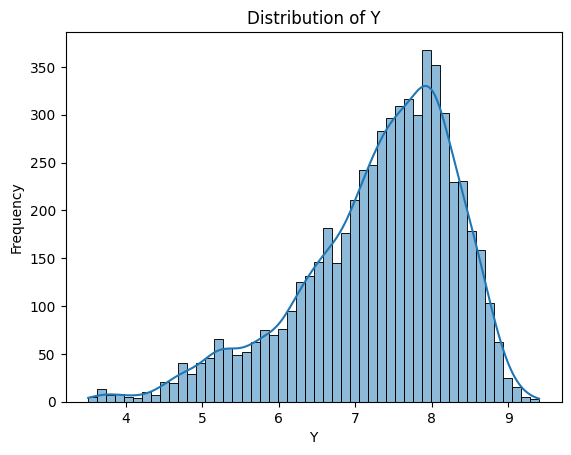

In [31]:
sns.histplot(Y, bins=50, kde=True)
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.title('Distribution of Y')
plt.show()

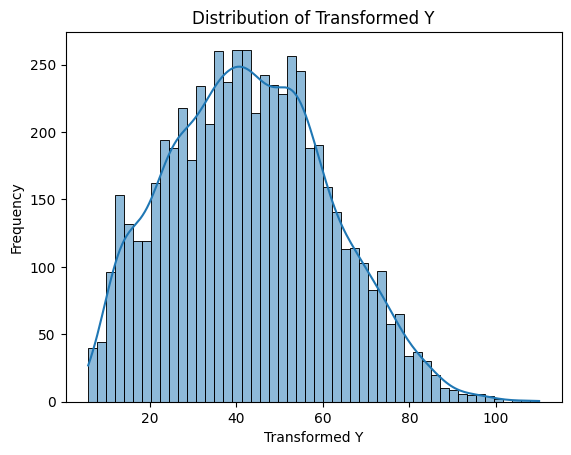

In [32]:
# Inverse log transform Y
Y_inverse_log = np.exp(Y)

# Apply square root transformation
Y_sqrt = np.sqrt(Y_inverse_log)
# Create a DataFrame to hold the transformed values
# sqrt_df = pd.DataFrame({
#     'Original Y': Y,
#     'Inverse Log Y': Y_inverse_log,
#     'Square Root Y': Y_sqrt
# })
# Display the transformed Y
sns.histplot(Y_sqrt, bins=50, kde=True)
plt.xlabel('Transformed Y')
plt.ylabel('Frequency')
plt.title('Distribution of Transformed Y')
plt.show()

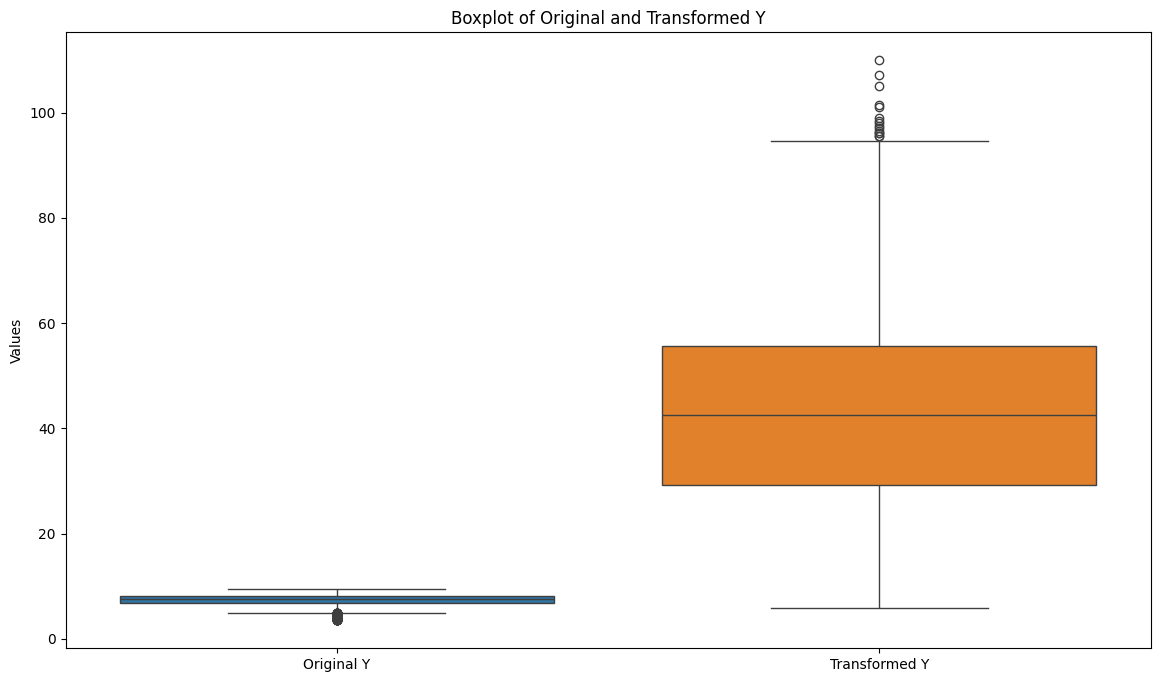

In [33]:
# Create a DataFrame to hold the original and transformed Y values
y_df = pd.DataFrame({
    'Original Y': Y,
    'Transformed Y': Y_sqrt
})

# Plot the boxplots
plt.figure(figsize=(14, 8))
sns.boxplot(data=y_df)
plt.title('Boxplot of Original and Transformed Y')
plt.ylabel('Values')
plt.show()

In [34]:
Y = Y_sqrt

In [35]:
def get_outliers_count(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

original_y_outliers = get_outliers_count(Y)
transformed_y_outliers = get_outliers_count(Y_sqrt)

print(f"Number of outliers in original Y: {original_y_outliers}")
print(f"Number of outliers in transformed Y: {transformed_y_outliers}")

Number of outliers in original Y: 15
Number of outliers in transformed Y: 15


In [36]:
X.head()

,ItemID,X2,FatContent,Visibility,Type,MRP,OutletID,Size,Location_Type,Outlet_Type,Category,SubCategory,SKU,PastYears,PastYearsCont
0,FDA15,9.30,LF,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,FD,A,15,old,10
1,DRC01,5.92,REG,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,DR,C,01,new,0
2,FDN15,17.50,LF,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,FD,N,15,old,10
3,FDX07,19.20,REG,0.000000,Fruits and Vegetables,182.0950,OUT010,NaN,Tier 3,Grocery Store,FD,X,07,old,11
4,NCD19,8.93,LF,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,NC,D,19,very old,22


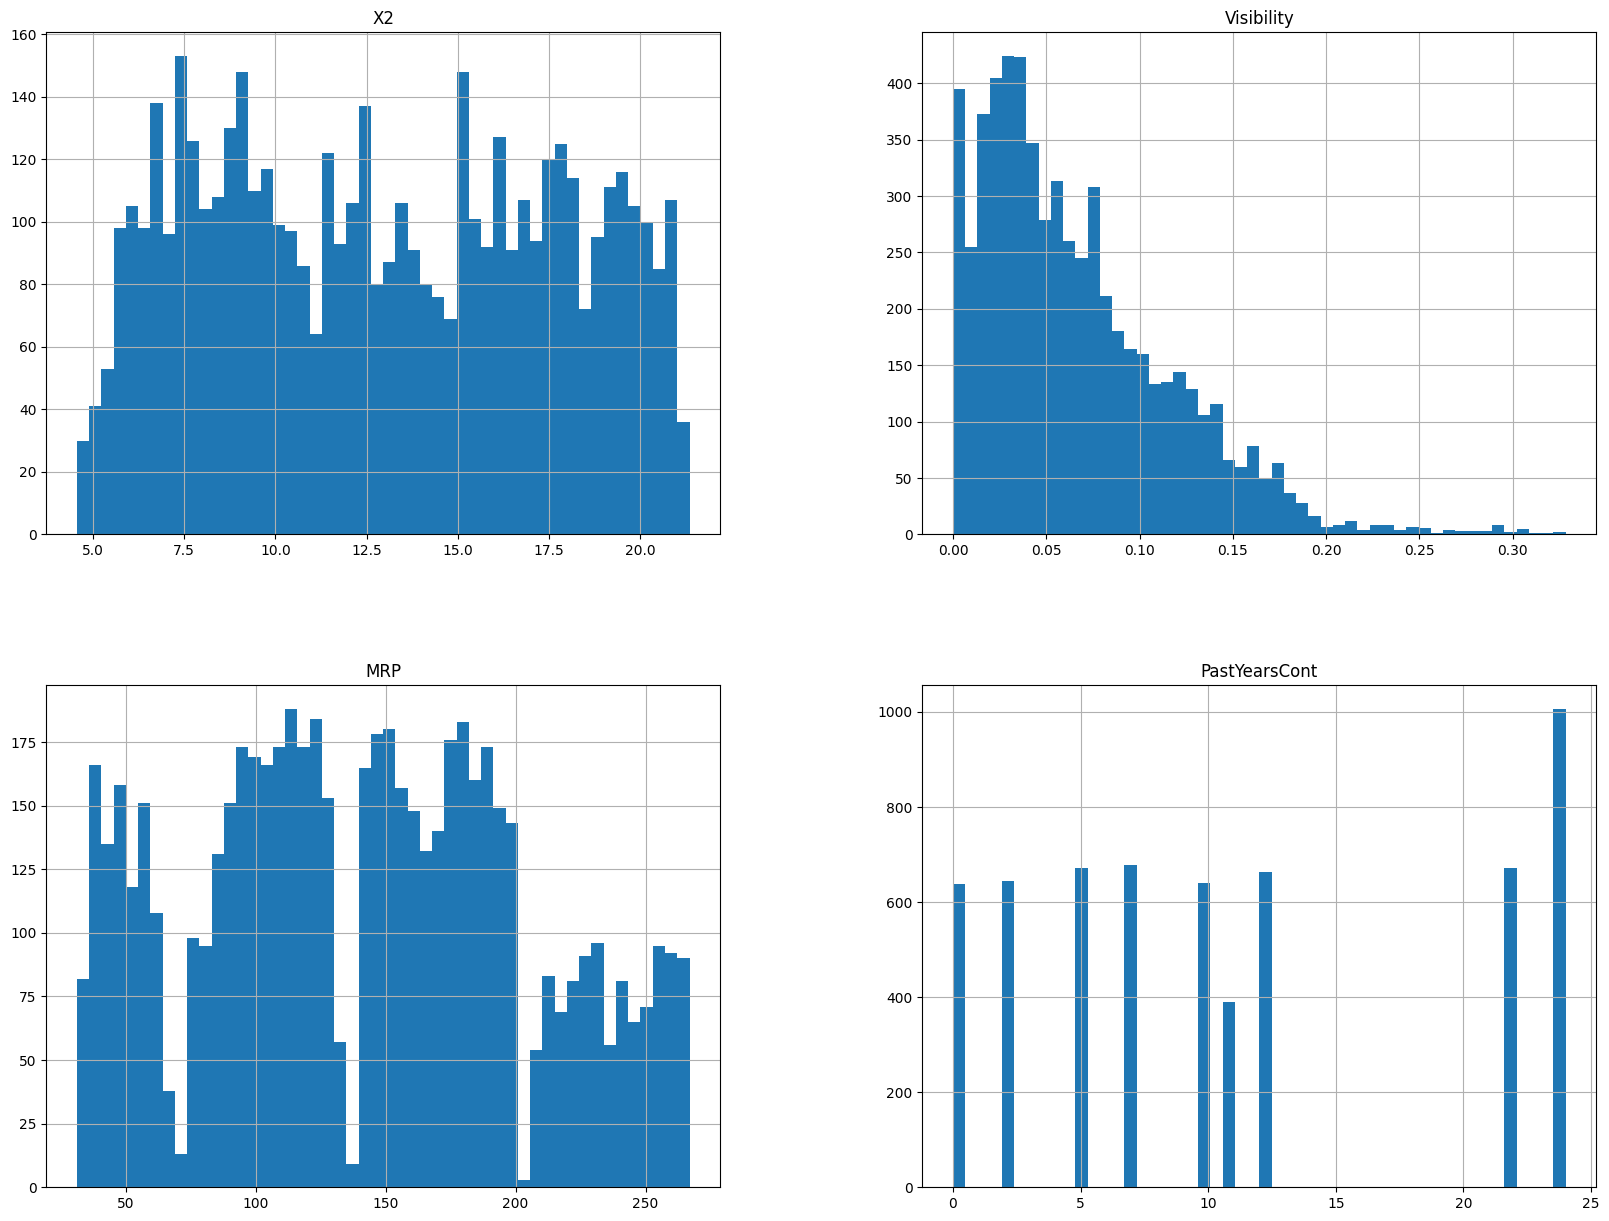

In [37]:
X.hist(bins=50, figsize=(20,15))
plt.show()

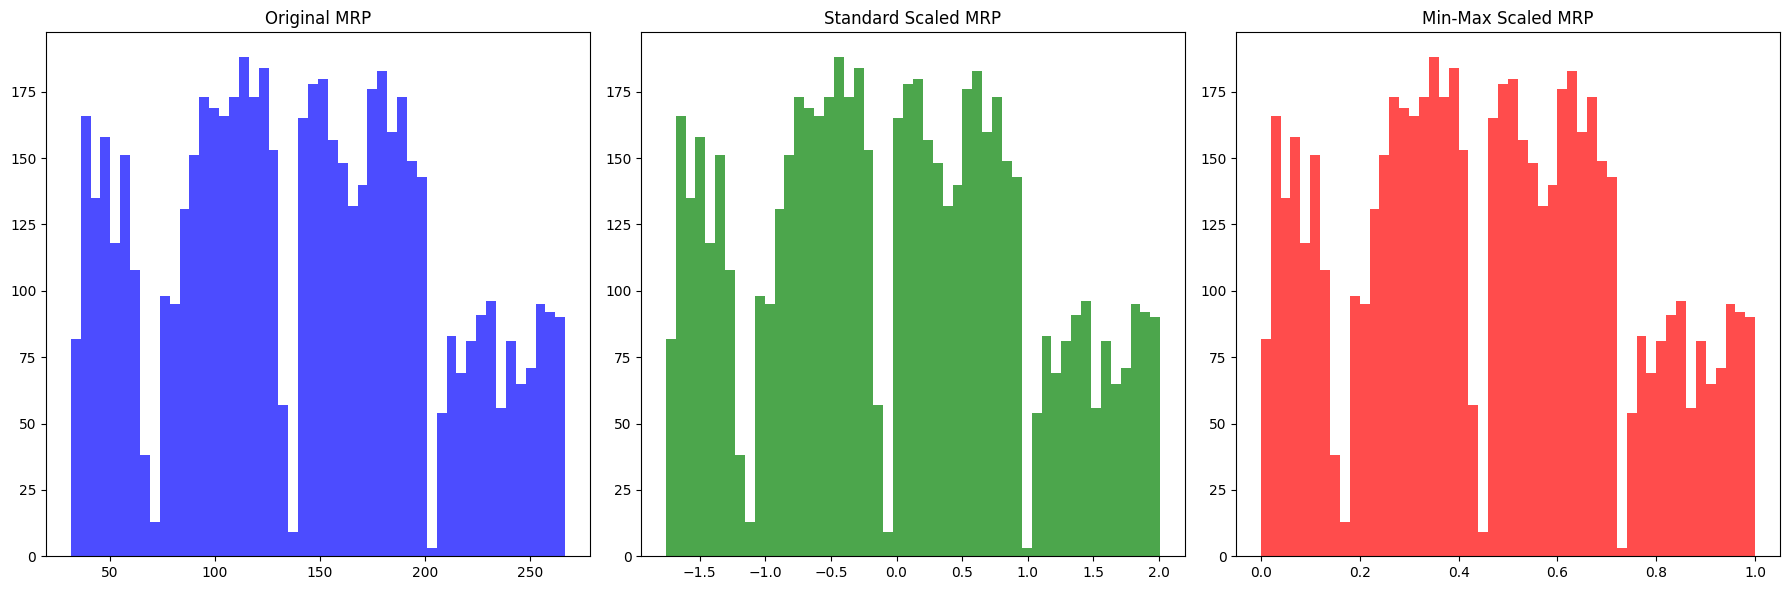

In [38]:
# Apply Standard Scaler and Min-Max Scaler to the MRP column
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

# Transform the MRP column
MRP_standard_scaled = standard_scaler.fit_transform(X[['MRP']])
MRP_min_max_scaled = min_max_scaler.fit_transform(X[['MRP']])

# Create a DataFrame to hold the transformed values
transformed_MRP = pd.DataFrame({
    'Original MRP': X['MRP'],
    'Standard Scaled MRP': MRP_standard_scaled.flatten(),
    'Min-Max Scaled MRP': MRP_min_max_scaled.flatten()
})

# Plot the transformed values
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Original MRP
axes[0].hist(transformed_MRP['Original MRP'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Original MRP')

# Standard Scaled MRP
axes[1].hist(transformed_MRP['Standard Scaled MRP'], bins=50, color='green', alpha=0.7)
axes[1].set_title('Standard Scaled MRP')

# Min-Max Scaled MRP
axes[2].hist(transformed_MRP['Min-Max Scaled MRP'], bins=50, color='red', alpha=0.7)
axes[2].set_title('Min-Max Scaled MRP')

plt.tight_layout()
plt.show()

X2 is well distributed, Visibility is right skweded need log transformstion, MRP is clustered, might make a category out of it, Years betwee 27-37 missing, might make cluster Before 27 , After 27

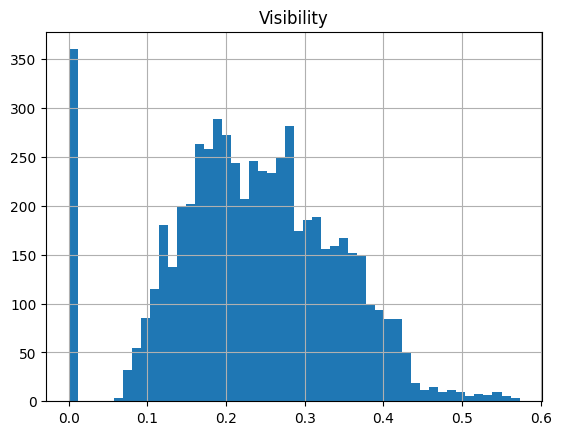

In [39]:
SqrVisibility = np.sqrt(X["Visibility"])
sqr = pd.DataFrame(SqrVisibility)
sqr.hist(bins=50)
plt.show()

array([[<Axes: title={'center': 'Visibility'}>,
        <Axes: title={'center': 'LOGVisibility'}>]], dtype=object)

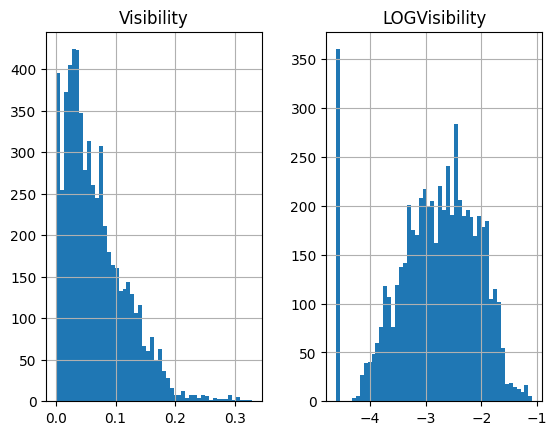

In [40]:
LOGVisibility = np.log(X["Visibility"]+0.01) 
diff = pd.DataFrame({"Visibility": X["Visibility"], "LOGVisibility": LOGVisibility})
diff.hist(bins=50)

<Axes: >

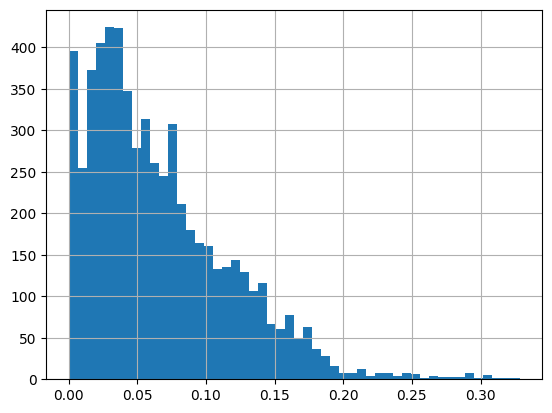

In [41]:
#X["Visibility"] =  np.sqrt(X["Visibility"])
X["Visibility"].hist(bins=50)

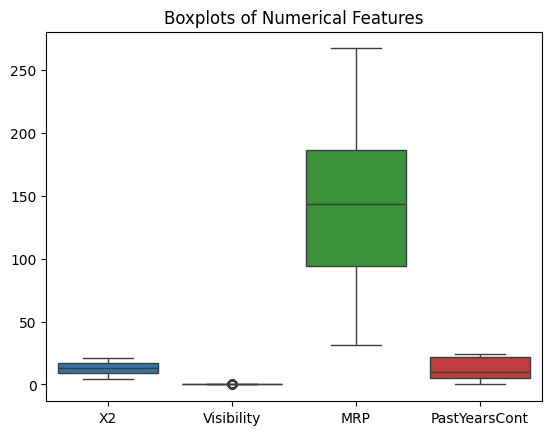

In [42]:
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()
# Generate boxplots for numerical features
#plt.figure(figsize=(15, 10))
sns.boxplot(data=X[numerical_features], orient='v')
plt.title('Boxplots of Numerical Features')
plt.show()


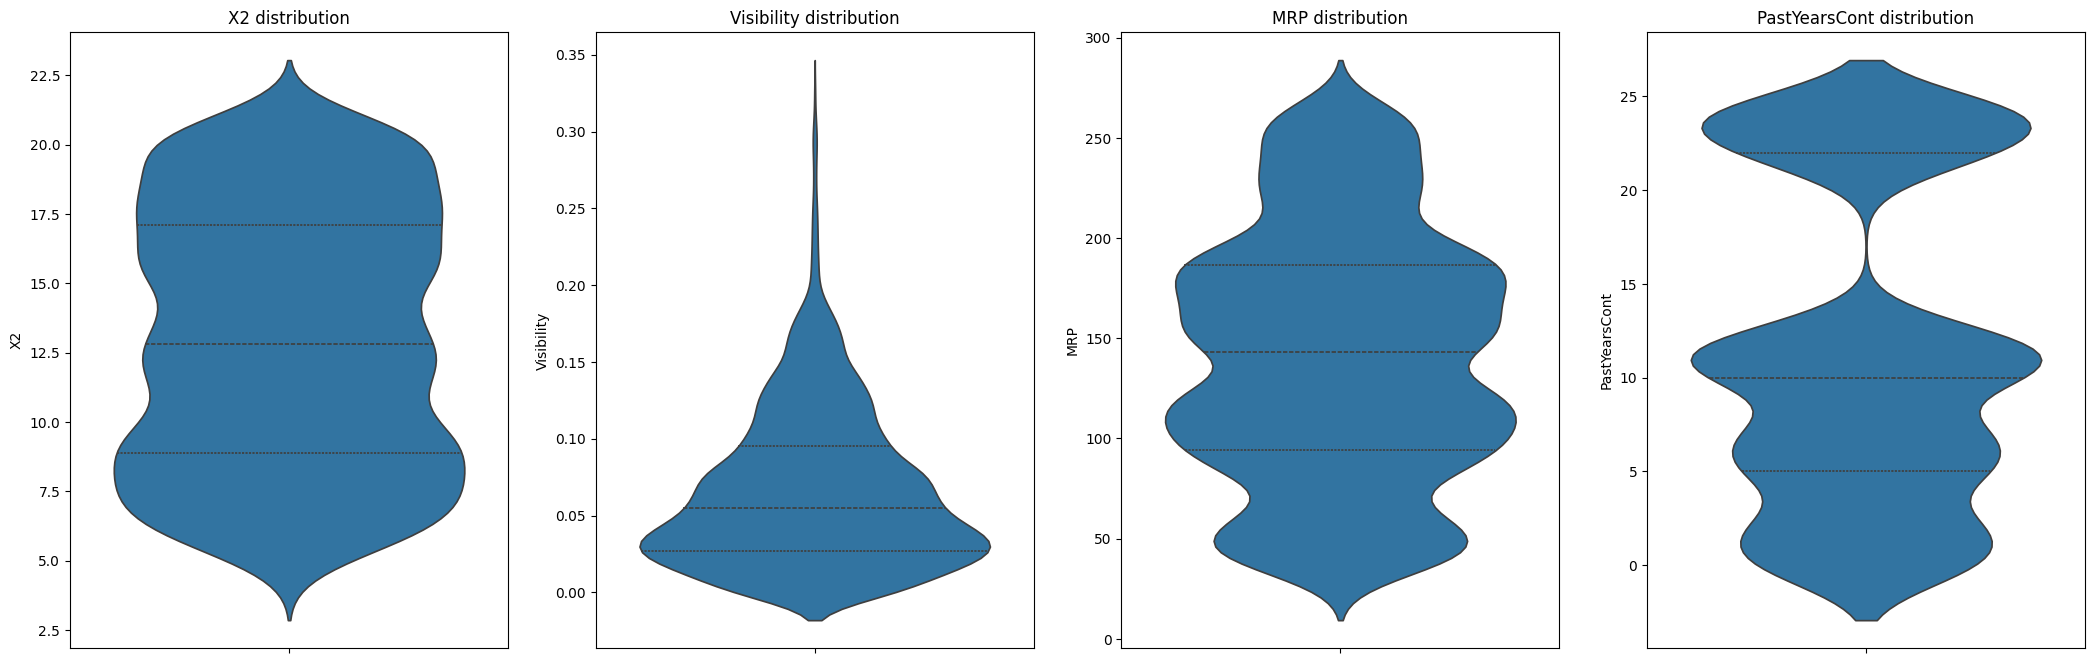

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(26,8))
for index, col in enumerate(numerical_features):
    sns.violinplot(data=X, y=col, ax=ax[index], inner='quartile')
    ax[index].set_title(f'{col} distribution')

In [44]:
for col in categorical_features:
    print(f"Column: {col}")
    print(X[col].value_counts())
    print("\n")                   

Column: ItemID
ItemID
FDP28    8
DRE49    8
NCF42    8
NCQ43    8
FDW24    8
        ..
FDN50    1
FDY43    1
FDM57    1
FDZ50    1
FDX13    1
Name: count, Length: 1553, dtype: int64


Column: FatContent
FatContent
LF     3889
REG    2111
Name: count, dtype: int64


Column: Type
Type
Fruits and Vegetables    875
Snack Foods              840
Household                643
Frozen Foods             621
Dairy                    487
Canned                   455
Baking Goods             454
Health and Hygiene       342
Soft Drinks              311
Meat                     294
Breads                   182
Hard Drinks              150
Others                   117
Starchy Foods            108
Breakfast                 75
Seafood                   46
Name: count, dtype: int64


Column: OutletID
OutletID
OUT045    677
OUT013    672
OUT035    671
OUT046    664
OUT027    659
OUT017    644
OUT049    639
OUT018    637
OUT010    390
OUT019    347
Name: count, dtype: int64


Column: Size
Size
Medium    1

In [45]:
X["SKU"] = X["SKU"].astype(int)
X = X.drop("SubCategory", axis=1)  
categorical_features.remove("SubCategory")
#dropping the subcategory column as it has a lot of categories and it is not clear what it represents 

C:\Users\shels\AppData\Local\Temp\ipykernel_12540\3335298843.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.countplot(data=X, x=col, ax=ax[r][c], palette="viridis", width=0.6)
C:\Users\shels\AppData\Local\Temp\ipykernel_12540\3335298843.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
C:\Users\shels\AppData\Local\Temp\ipykernel_12540\3335298843.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.countplot(data=X, x=col, ax=ax[r][c], palette="viridis", width=0.6)
C:\Users\shels\AppData\Local\Temp\ipykernel_12540\3335298843.py:11:

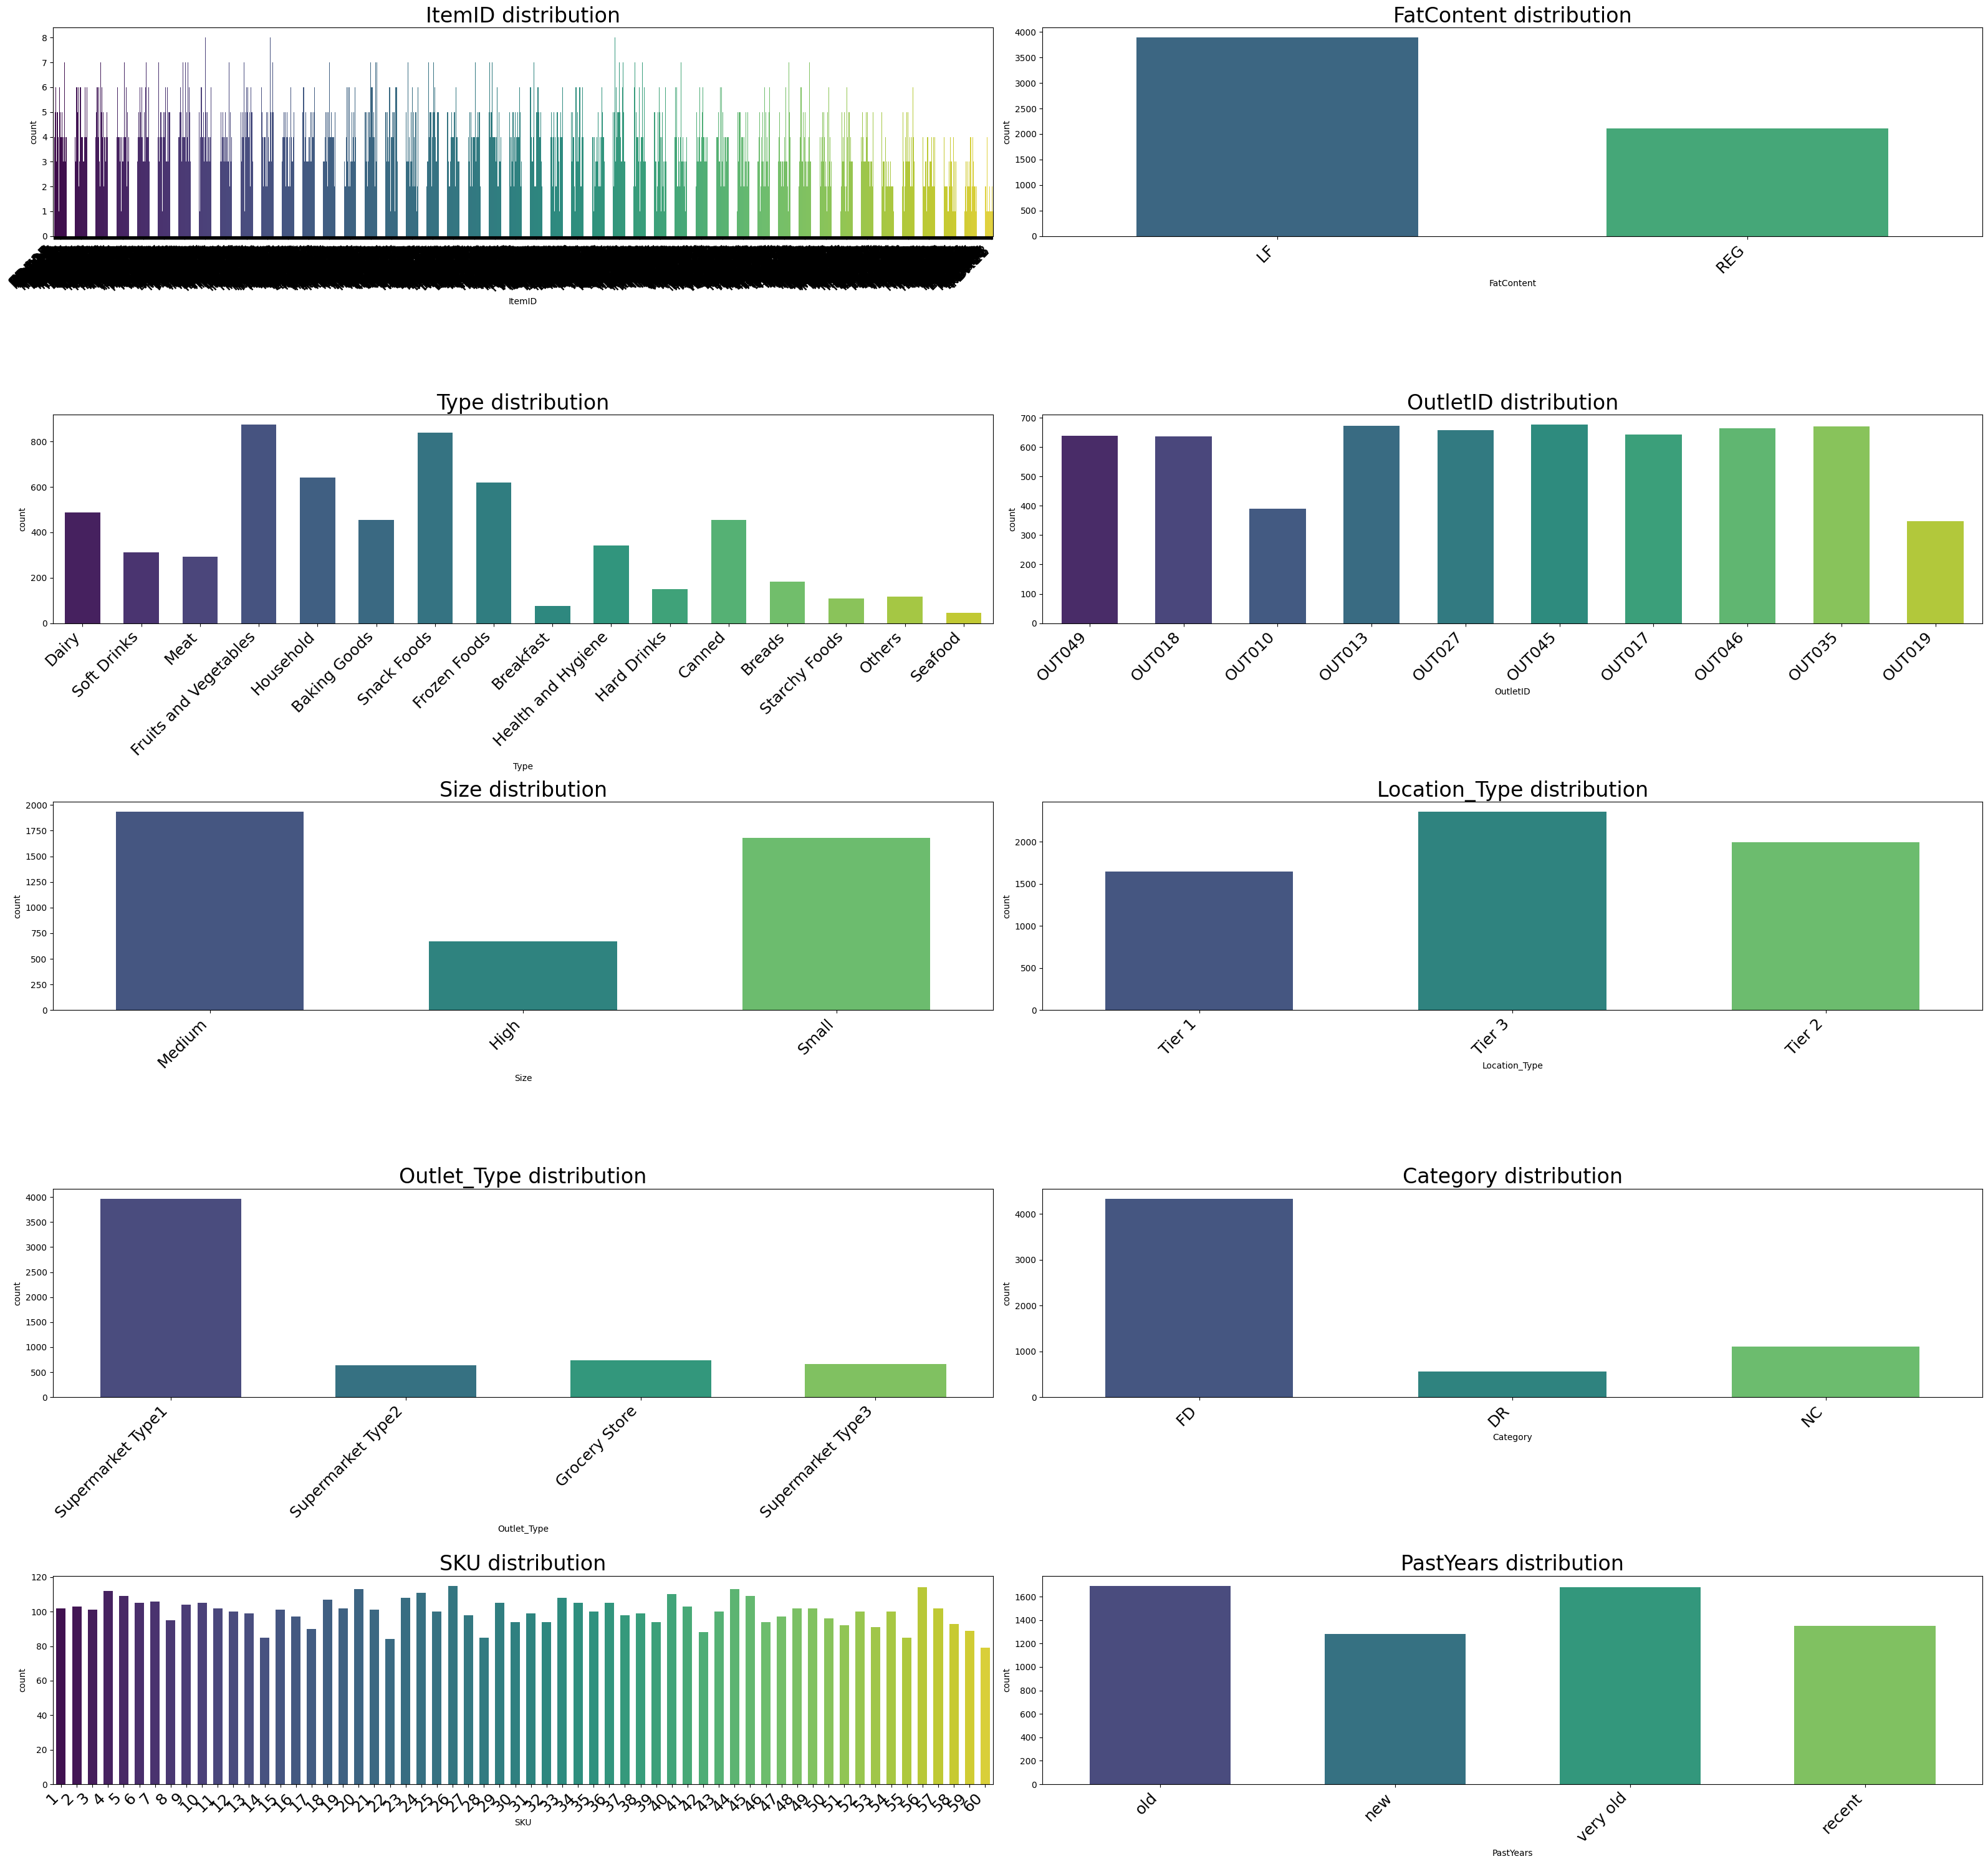

In [46]:
num_plots = len(categorical_features)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

_, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(32, 6 * num_rows))

for index, col in enumerate(categorical_features):
    r = index // num_cols
    c = index % num_cols
    g = sns.countplot(data=X, x=col, ax=ax[r][c], palette="viridis", width=0.6)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

## Target Transformation

<Axes: ylabel='Frequency'>

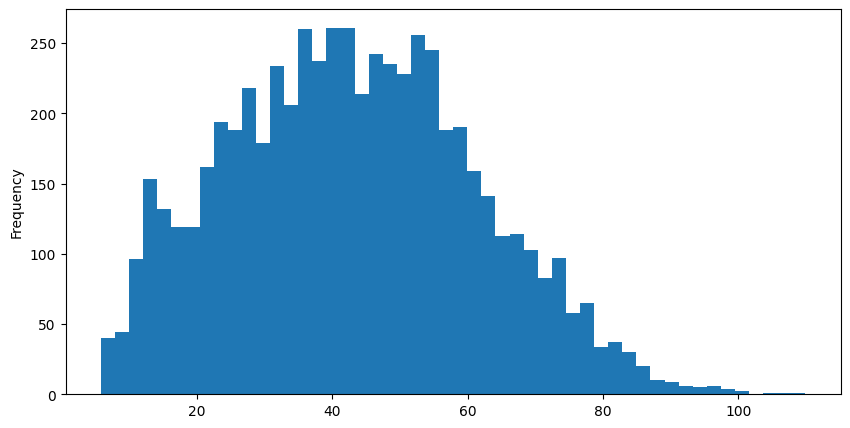

In [47]:
Y.plot(kind="hist", bins=50, figsize=(10, 5))

In [48]:
Y.describe()

count    6000.000000
mean       43.056341
std        18.309844
min         5.783448
25%        29.224284
50%        42.521082
75%        55.701106
max       109.947172
Name: Y, dtype: float64

## Bivariate analysis (relationship between variables)

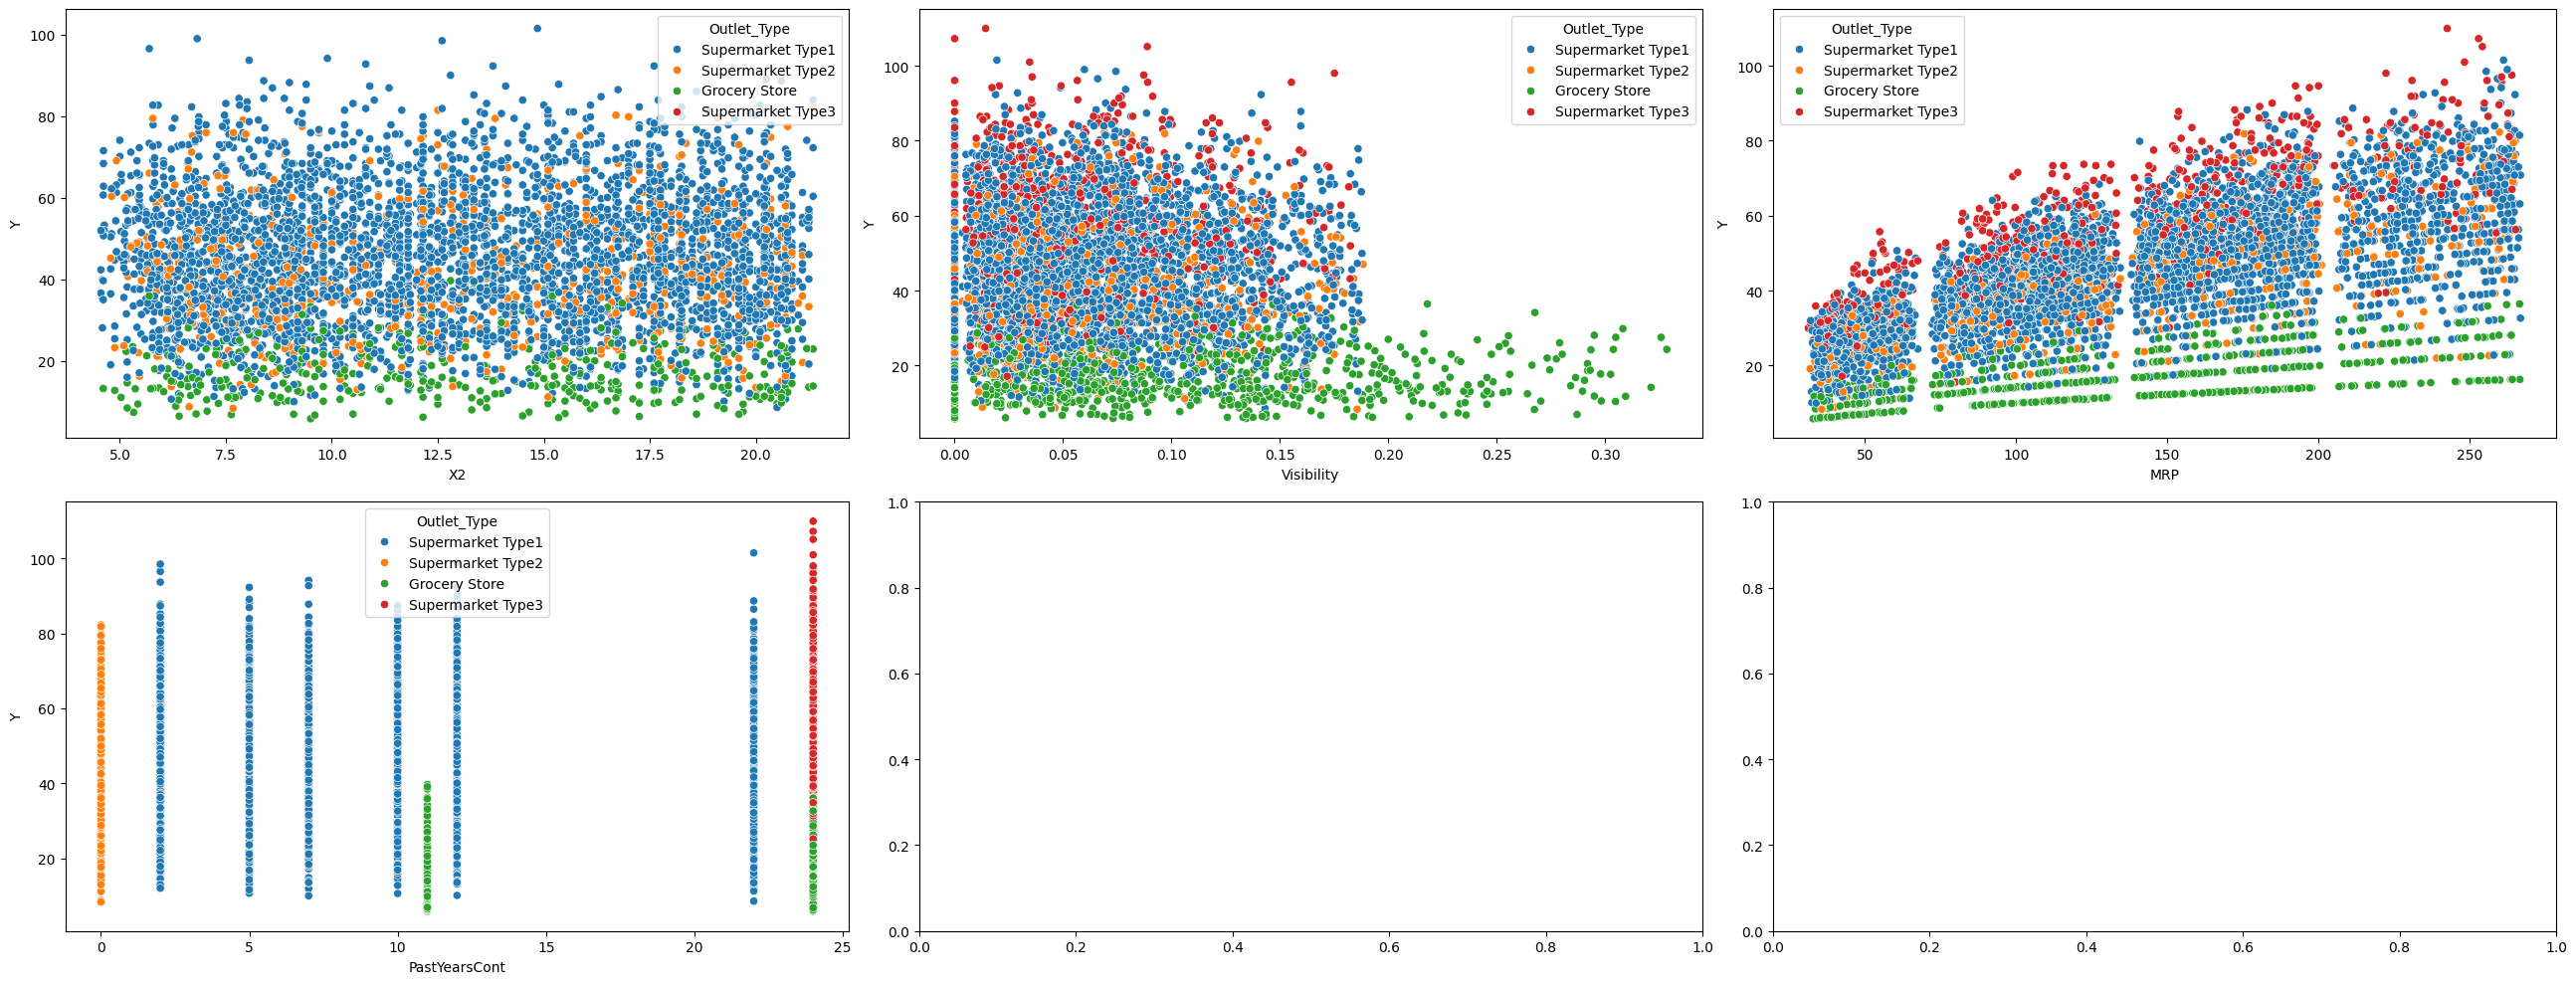

In [49]:
num_plots = len(numerical_features)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(26, 5 * num_rows))

for index, col in enumerate(numerical_features):
    r = index // num_cols
    c = index % num_cols
    if num_rows == 1:
        sns.scatterplot(data=X, x=col, y=Y, ax=ax[c], hue='Outlet_Type')
    else:
        sns.scatterplot(data=X, x=col, y=Y, ax=ax[r][c], hue='Outlet_Type')

plt.tight_layout()
plt.show()

supermarket type is very important

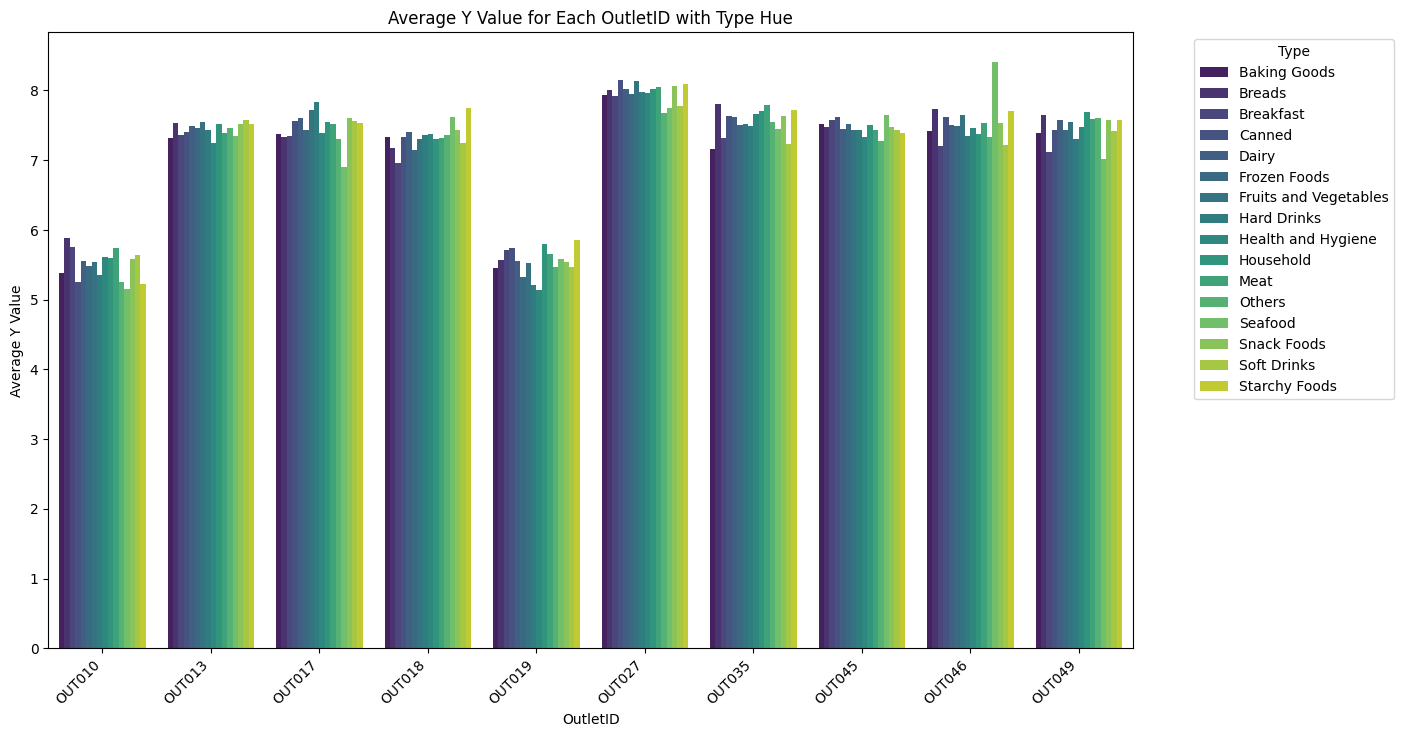

In [50]:
# Calculate the average Y value for each Type
average_Y_per_outlet_type = data1.groupby(['OutletID', 'Type'])['Y'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='OutletID', y='Y', hue='Type', data=average_Y_per_outlet_type, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Average Y Value for Each OutletID with Type Hue')
plt.xlabel('OutletID')
plt.ylabel('Average Y Value')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

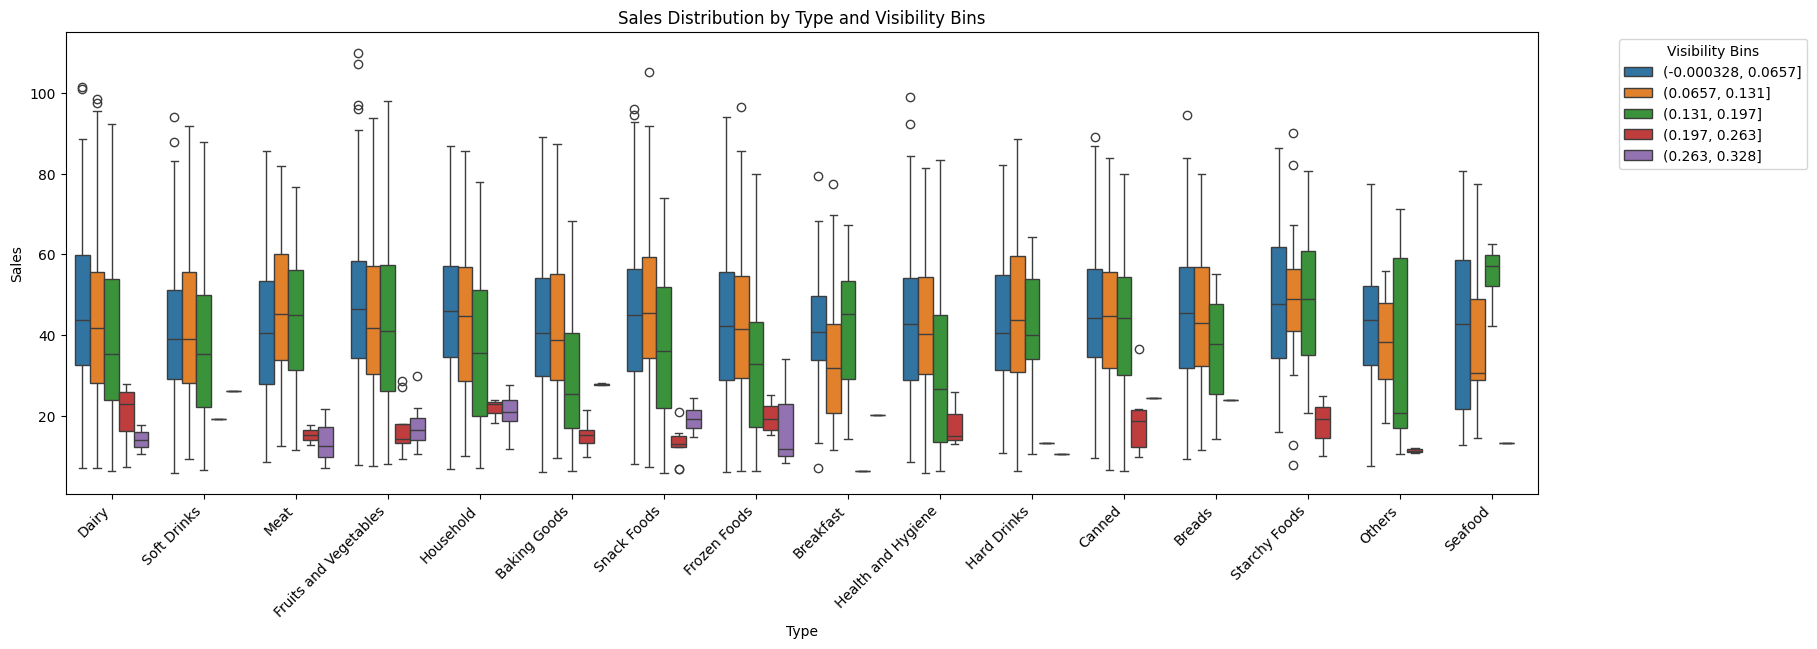

In [51]:


# Assuming 'df' is your DataFrame
# Columns: 'Visibility', 'Type', 'Sales'
# Binning Visibility into ranges
X['Visibility_bins'] = pd.cut(X['Visibility'], bins=5)
df = pd.concat([X, Y], axis=1)
# Boxplot of Sales grouped by Type and Visibility Bins
plt.figure(figsize=(19, 6))
sns.boxplot(x='Type', y='Y', hue='Visibility_bins', data=df)
plt.title("Sales Distribution by Type and Visibility Bins")
plt.xlabel("Type")
plt.ylabel("Sales")
plt.xticks(rotation=45, ha='right')  # Rotate Type names
plt.legend(title="Visibility Bins", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


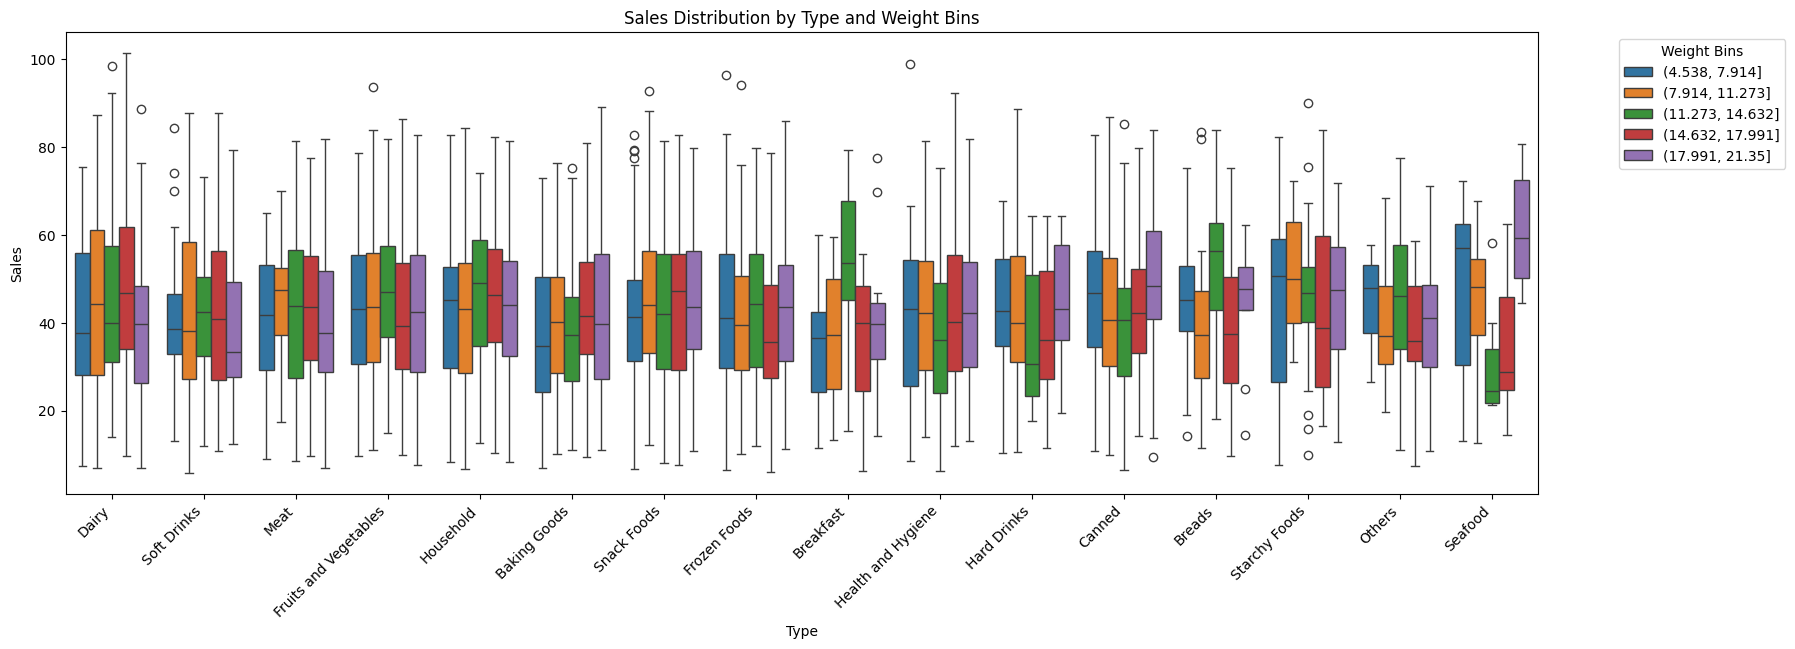

In [52]:
X['Visibility_bins'] = pd.cut(X['X2'], bins=5)
df = pd.concat([X, Y], axis=1)
# Boxplot of Sales grouped by Type and Visibility Bins
plt.figure(figsize=(19, 6))
sns.boxplot(x='Type', y='Y', hue='Visibility_bins', data=df)
plt.title("Sales Distribution by Type and Weight Bins")
plt.xlabel("Type")
plt.ylabel("Sales")
plt.xticks(rotation=45, ha='right')  # Rotate Type names
plt.legend(title="Weight Bins", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Weight with: seafood, Breakfast,canned

In [53]:
X['Type'].value_counts()
type_percentages = X['Type'].value_counts(normalize=True) * 100
print(type_percentages)

Type
Fruits and Vegetables    14.583333
Snack Foods              14.000000
Household                10.716667
Frozen Foods             10.350000
Dairy                     8.116667
Canned                    7.583333
Baking Goods              7.566667
Health and Hygiene        5.700000
Soft Drinks               5.183333
Meat                      4.900000
Breads                    3.033333
Hard Drinks               2.500000
Others                    1.950000
Starchy Foods             1.800000
Breakfast                 1.250000
Seafood                   0.766667
Name: proportion, dtype: float64


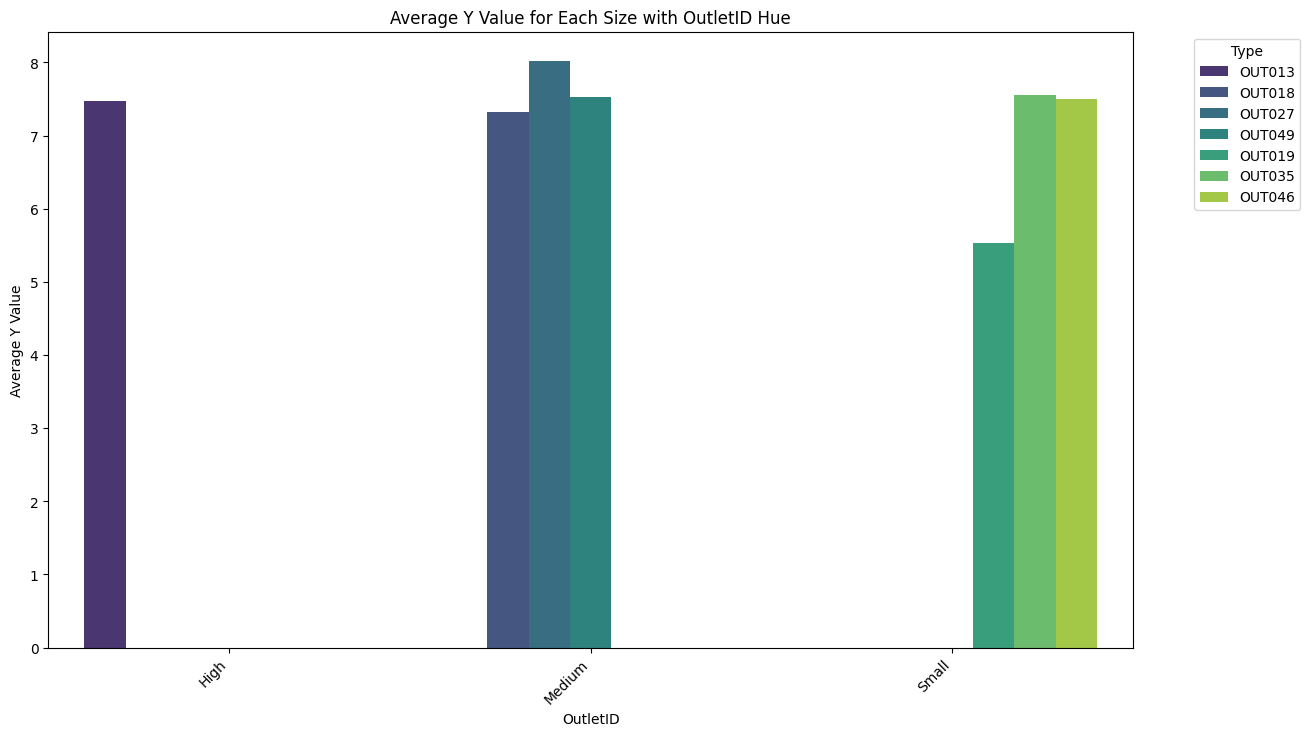

In [54]:
average_Y_per_outlet_type = data1.groupby(['Size', 'OutletID'])['Y'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Size', y='Y', hue='OutletID', data=average_Y_per_outlet_type, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Average Y Value for Each Size with OutletID Hue')
plt.xlabel('OutletID')
plt.ylabel('Average Y Value')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [55]:
outlet_ids_per_type = df.groupby('Outlet_Type')['OutletID'].unique()
print(outlet_ids_per_type)

Outlet_Type
Grocery Store                                        [OUT010, OUT019]
Supermarket Type1    [OUT049, OUT013, OUT045, OUT017, OUT046, OUT035]
Supermarket Type2                                            [OUT018]
Supermarket Type3                                            [OUT027]
Name: OutletID, dtype: object


In [56]:
data1.head()

,ItemID,X2,FatContent,Visibility,Type,MRP,OutletID,EstablishmentYear,Size,Location_Type,Outlet_Type,Y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.23
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.09
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.65
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,6.60
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.90


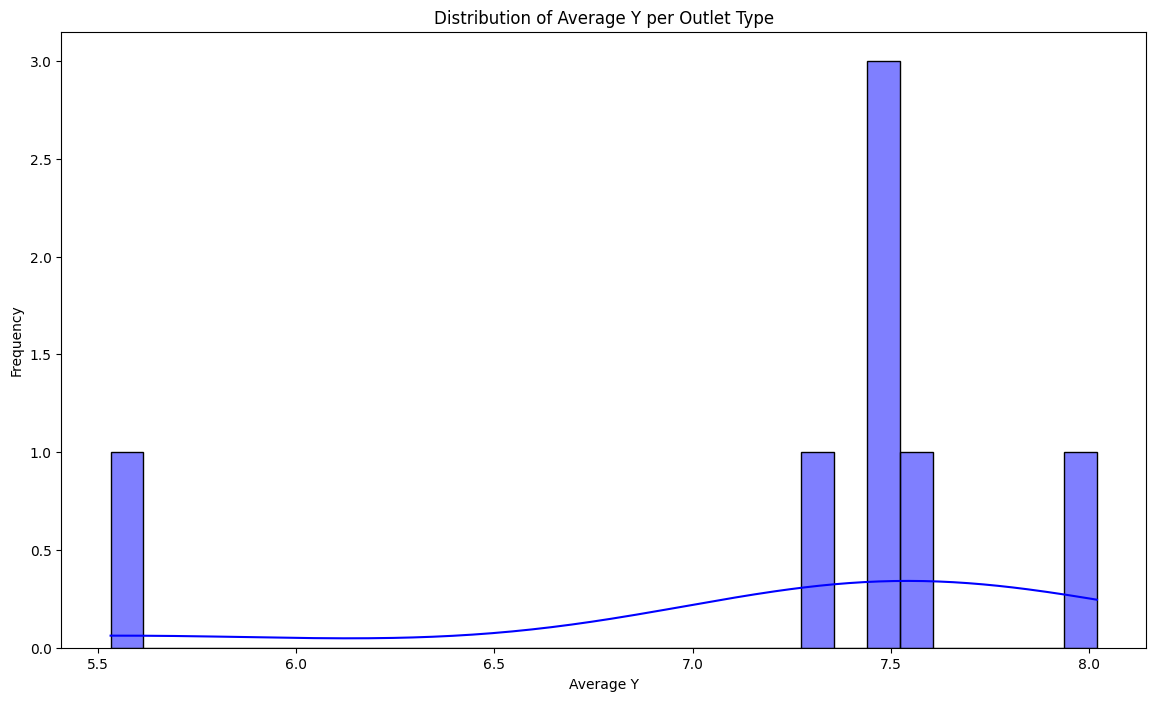

In [57]:
plt.figure(figsize=(14, 8))
sns.histplot(average_Y_per_outlet_type['Y'], bins=30, kde=True, color='blue')
plt.title('Distribution of Average Y per Outlet Type')
plt.xlabel('Average Y')
plt.ylabel('Frequency')
plt.show()

I dont want to do standars scaling as i want to perserve the positive values as these are prices, so MIn-Max seem the best transformation to perservew the distribution byut within range

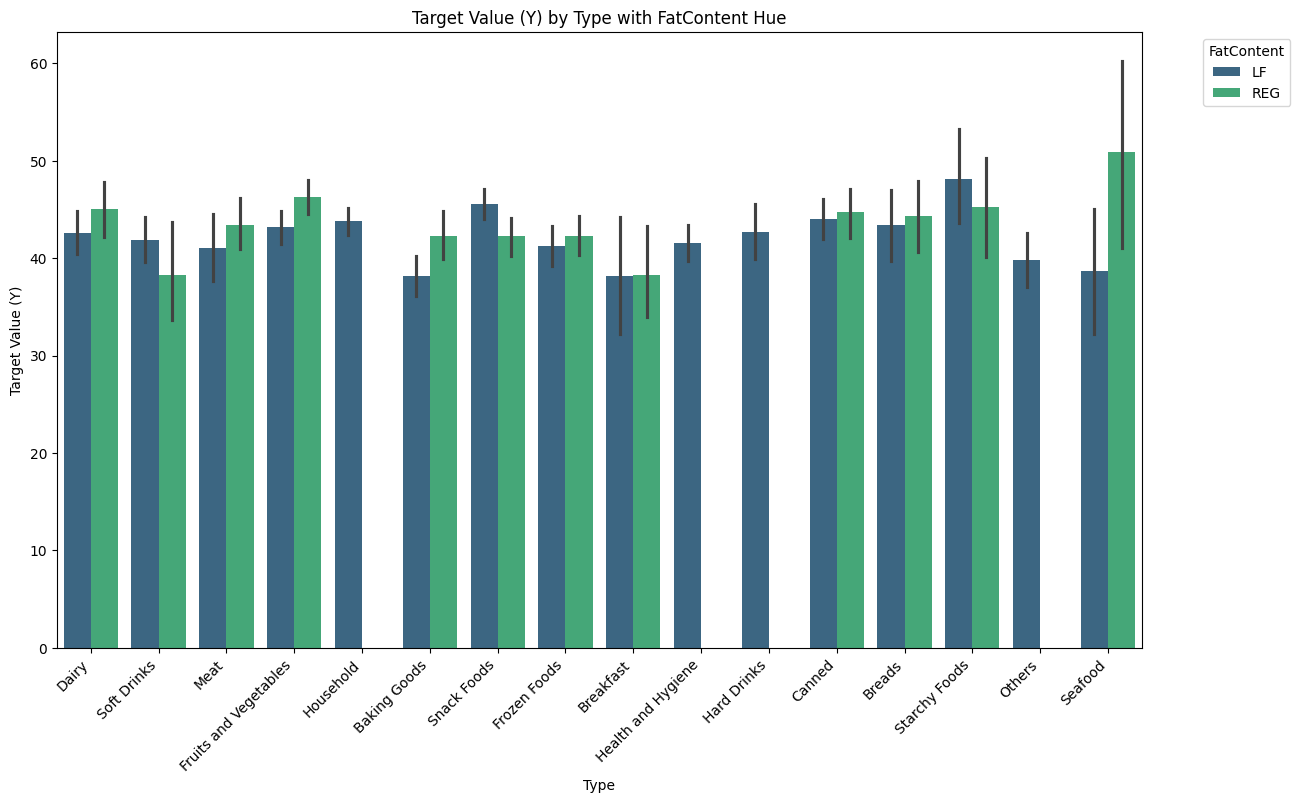

In [58]:
X['Y'] = Y
plt.figure(figsize=(14, 8))
sns.barplot(x='Type', y=Y, hue='FatContent', data=X, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Target Value (Y) by Type with FatContent Hue')
plt.xlabel('Type')
plt.ylabel('Target Value (Y)')
plt.legend(title='FatContent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

No big difference in price between a type of Reg fat and low

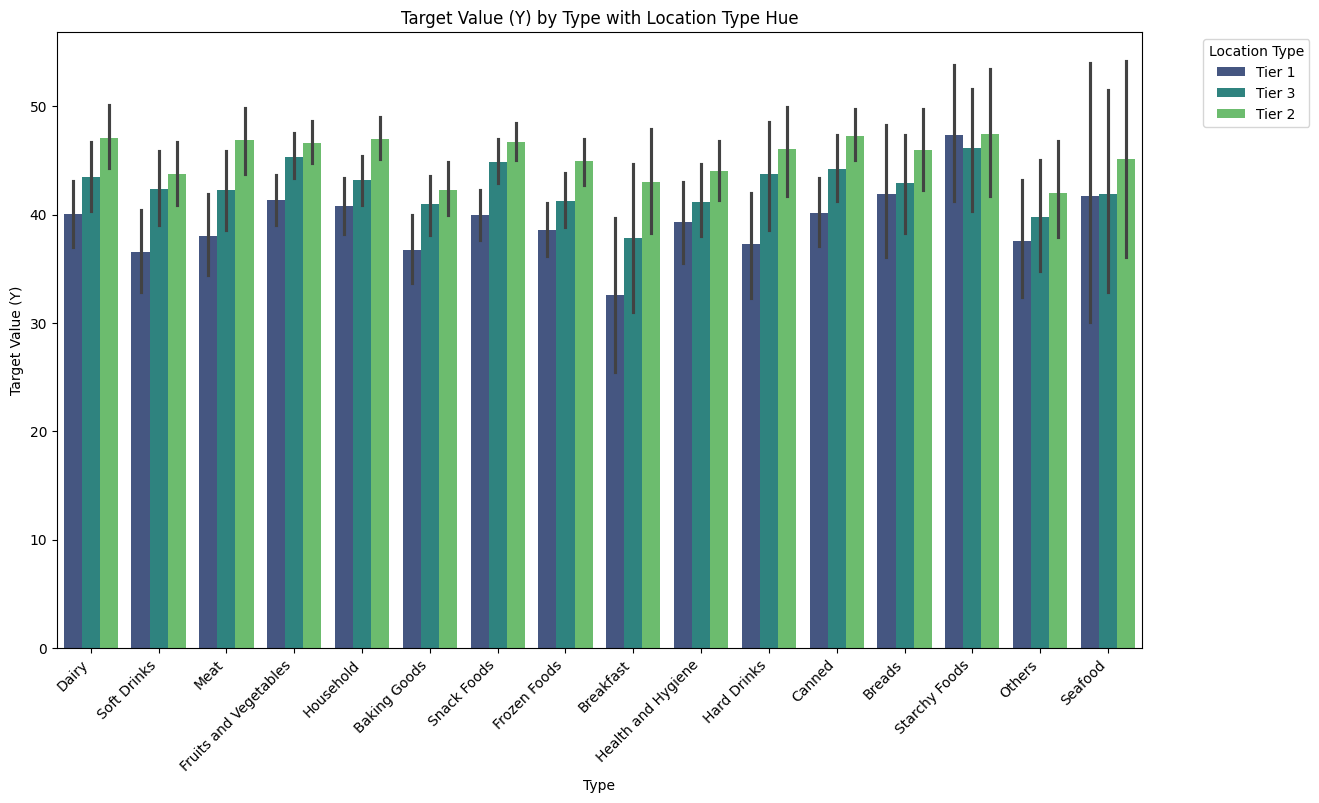

In [59]:
X['Y'] = Y
plt.figure(figsize=(14, 8))
sns.barplot(x='Type', y=Y, hue='Location_Type', data=X, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Target Value (Y) by Type with Location Type Hue')
plt.xlabel('Type')
plt.ylabel('Target Value (Y)')
plt.legend(title='Location Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

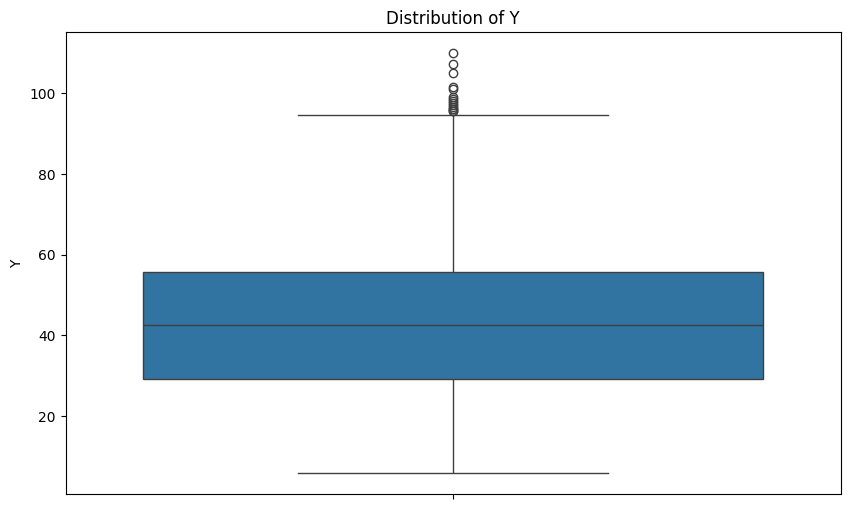

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=Y)
plt.title('Distribution of Y')
plt.ylabel('Y')
plt.show()

In [61]:
def get_outliers_count(df, numerical_features):
    outliers_count = {}
    for col in numerical_features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count[col] = outliers.shape[0]
    return outliers_count

outliers_count_Y = get_outliers_count(pd.DataFrame(Y), ['Y'])
print(outliers_count_Y)

{'Y': 15}


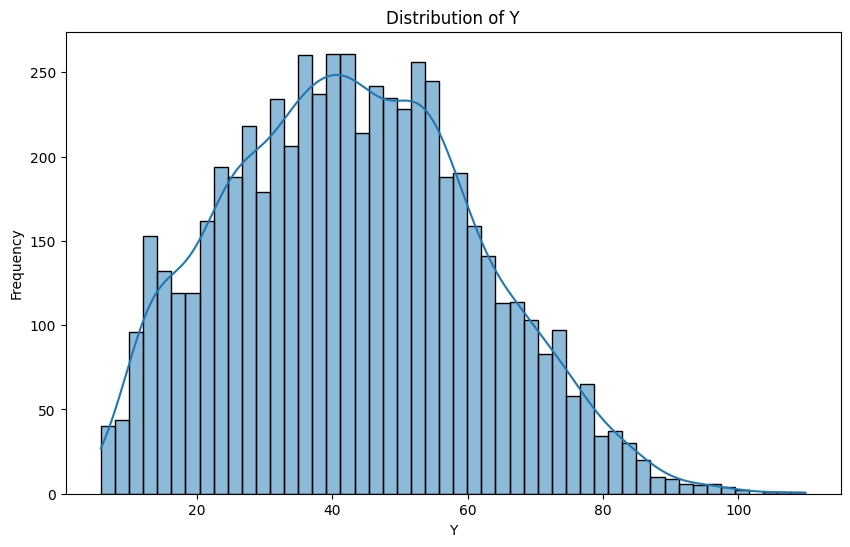

In [62]:
plt.figure(figsize=(10, 6))
sns.histplot(Y, bins=50, kde=True)
plt.title('Distribution of Y')
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.show()

In [63]:
#cluster mrp
#remove outlier from each mrp cluster
# inverse log sales then square root
# nc lowfat to nofat

In [64]:
from scipy.stats import skew

# Measure skewness of Y
y_skewness = skew(Y)
print(f"Skewness of Y: {y_skewness}")

# Identify outliers in Y using IQR method
Q1 = Y.quantile(0.25)
Q3 = Y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = Y[(Y < lower_bound) | (Y > upper_bound)]

print(f"Number of outliers in Y: {len(outliers)}")
#print(f"Outliers in Y:\n{outliers}")

Skewness of Y: 0.22407255474424614
Number of outliers in Y: 15


In [65]:
outlier_rows = X[Y.isin(outliers)]
outlier_rows.head(30)

,ItemID,X2,FatContent,Visibility,Type,MRP,OutletID,Size,Location_Type,Outlet_Type,Category,SKU,PastYears,PastYearsCont,Visibility_bins,Y
333,FDN58,NaN,REG,0.056597,Snack Foods,230.9984,OUT027,Medium,Tier 3,Supermarket Type3,FD,58,very old,24,NaN,96.062594
456,FDS26,NaN,LF,0.089036,Dairy,260.5594,OUT027,Medium,Tier 3,Supermarket Type3,FD,26,very old,24,NaN,95.583480
991,FDS44,NaN,REG,0.155288,Fruits and Vegetables,241.7538,OUT027,Medium,Tier 3,Supermarket Type3,FD,44,very old,24,NaN,95.583480
997,FDK28,5.695,LF,0.065961,Frozen Foods,259.2646,OUT017,NaN,Tier 2,Supermarket Type1,FD,28,new,2,"(4.538, 7.914]",96.544110
1009,FDU14,NaN,LF,0.034584,Dairy,248.3750,OUT027,Medium,Tier 3,Supermarket Type3,FD,14,very old,24,NaN,100.987829
1450,FDZ20,NaN,LF,0.000000,Fruits and Vegetables,253.0356,OUT027,Medium,Tier 3,Supermarket Type3,FD,20,very old,24,NaN,107.232567
2109,FDU55,NaN,LF,0.035737,Fruits and Vegetables,260.6278,OUT027,Medium,Tier 3,Supermarket Type3,FD,55,very old,24,NaN,97.028039
3098,FDY02,NaN,REG,0.087221,Dairy,263.9910,OUT027,Medium,Tier 3,Supermarket Type3,FD,2,very old,24,NaN,97.514394
4289,NCM05,6.825,LF,0.059847,Health and Hygiene,262.5226,OUT046,Small,Tier 1,Supermarket Type1,NC,5,old,12,"(4.538, 7.914]",98.988136
4346,FDY55,NaN,LF,0.000000,Fruits and Vegetables,255.7988,OUT027,Medium,Tier 3,Supermarket Type3,FD,55,very old,24,NaN,96.062594


In [66]:
for col in outlier_rows.columns:
    print(f"Column: {col}")
    print(outlier_rows[col].value_counts())
    print("\n")

Column: ItemID
ItemID
FDN58    1
FDS26    1
FDS44    1
FDK28    1
FDU14    1
FDZ20    1
FDU55    1
FDY02    1
NCM05    1
FDY55    1
FDP33    1
FDF39    1
FDK03    1
FDQ19    1
FDG32    1
Name: count, dtype: int64


Column: X2
X2
5.695     1
6.825     1
14.850    1
12.600    1
Name: count, dtype: int64


Column: FatContent
FatContent
LF     9
REG    6
Name: count, dtype: int64


Column: Visibility
Visibility
0.000000    2
0.056597    1
0.089036    1
0.155288    1
0.065961    1
0.034584    1
0.035737    1
0.087221    1
0.059847    1
0.088840    1
0.019495    1
0.074339    1
0.014296    1
0.175143    1
Name: count, dtype: int64


Column: Type
Type
Fruits and Vegetables    6
Dairy                    5
Snack Foods              2
Frozen Foods             1
Health and Hygiene       1
Name: count, dtype: int64


Column: MRP
MRP
230.9984    1
260.5594    1
241.7538    1
259.2646    1
248.3750    1
253.0356    1
260.6278    1
263.9910    1
262.5226    1
255.7988    1
254.2672    1
261.2910    1


tier 2 seems highest then tier 3 then tier 1, see ordinal categories in pipeline!

# Handling missing Values

### univariate imputation

there are 2 indicators to choose the best imputation method, first is for the distribution of imputed data to be close to the original and second and most importantly to have the highest correlation aka mi to the target Y

<Axes: ylabel='Density'>

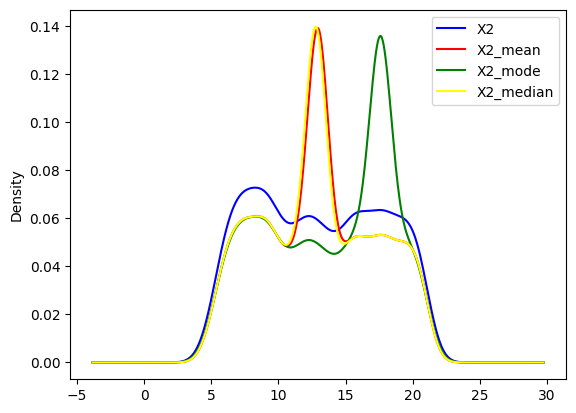

In [67]:
# mean, mode , interpolate
X["X2_mean"] = X["X2"].fillna(X["X2"].mean())
X["X2_mode"] = X["X2"].fillna(X["X2"].mode()[0])
X["X2_median"] = X["X2"].fillna(X["X2"].median())
X["X2"].plot(kind="kde", color="blue", legend=True)
X["X2_mean"].plot(kind="kde", color="red", legend=True)
X["X2_mode"].plot(kind="kde", color="green", legend=True)
X['X2_median'].plot(kind="kde", color="yellow", legend=True)

there is a lot of inconsistency wiht the data with mean and mode , now we try the interpolate, where it uses interpolation methods ASUx12! to fill missing numerical values

<Axes: ylabel='Density'>

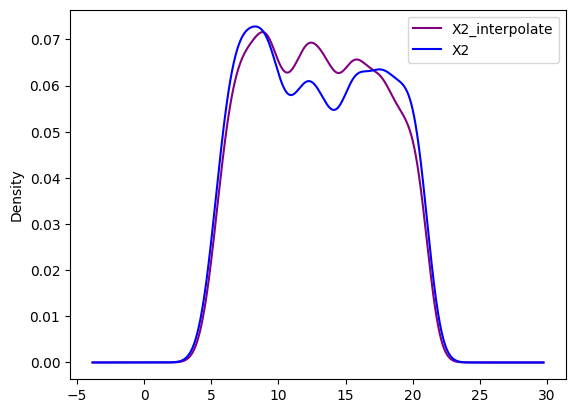

In [68]:
X["X2_interpolate"] = X["X2"].interpolate()
X["X2_interpolate"].plot(kind="kde", color="purple", legend=True)
X["X2"].plot(kind="kde", color="blue", legend=True)

In [69]:
corr_matrix = pd.concat([X[['X2','X2_mean', 'X2_mode',"X2_median",'X2_interpolate']], Y], axis=1).corr()
print("Correlation Matrix:")
print(corr_matrix)

# Calculate mutual information
mi = mutual_info_regression(X[['X2_mean', 'X2_mode','X2_median', 'X2_interpolate']], Y)
mi_df = pd.DataFrame({'Feature': ['X2_mean', 'X2_mode','X2_median', 'X2_interpolate'], 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

print("\nMutual Information:")
print(mi_df)

Correlation Matrix:
                    X2   X2_mean   X2_mode  X2_median  X2_interpolate  \
X2              1.0000  1.000000  1.000000   1.000000        1.000000   
X2_mean         1.0000  1.000000  0.925849   0.999905        0.955243   
X2_mode         1.0000  0.925849  1.000000   0.920562        0.879962   
X2_median       1.0000  0.999905  0.920562   1.000000        0.955314   
X2_interpolate  1.0000  0.955243  0.879962   0.955314        1.000000   
Y               0.0107  0.008977  0.015896   0.008700        0.006520   

                       Y  
X2              0.010700  
X2_mean         0.008977  
X2_mode         0.015896  
X2_median       0.008700  
X2_interpolate  0.006520  
Y               1.000000  

Mutual Information:
          Feature  Mutual Information
2       X2_median            0.048287
1         X2_mode            0.048184
0         X2_mean            0.045198
3  X2_interpolate            0.019785


surprisingly the interpolate hjas the lowest correlation and mode has the highest correlation

In [70]:
X.drop(["X2_mean","X2_median"], axis=1, inplace=True)
#we are deropping interpolate at the moment as we are going to add it in the pipeline

# univariate Imputation

here we are going to use KNN imputer, which it gets the the nearest distances based on the whole feature space and replace the missing value with the mean of these nearest K occurences.

C:\Users\shels\AppData\Local\Temp\ipykernel_12540\3663665388.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2Copy[["X2"]] = scaler.fit_transform(X2Copy[["X2"]])


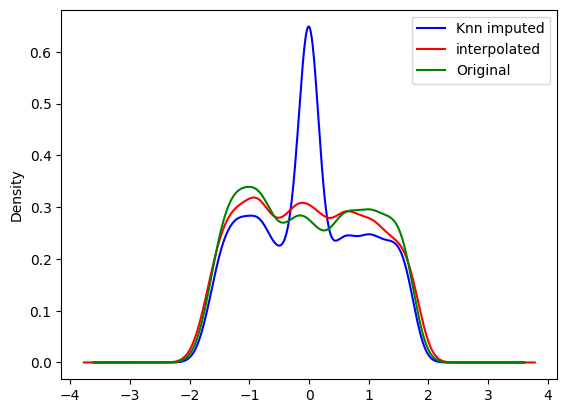

In [71]:
#first we need to standerdize the numerical columns and do ordinal encoding for the categorical columns
XCopy = X.copy()
# Standardize numerical columns
scaler = StandardScaler()
numerical_cols_XCopy = XCopy.select_dtypes(include=[np.number]).columns.tolist()
XCopy[numerical_cols_XCopy] = scaler.fit_transform(XCopy[numerical_cols_XCopy])
ordinal_colsXCOpy = XCopy.select_dtypes(include=[object]).columns.tolist()
X2Copy = X[["X2"]]
X2Copy.head()

# Ordinal encode categorical columns
ordinal_encoder = OrdinalEncoder()
XCopy[ordinal_colsXCOpy] = ordinal_encoder.fit_transform(XCopy[ordinal_colsXCOpy])
X2Copy[["X2"]] = scaler.fit_transform(X2Copy[["X2"]])
XCopy.drop(["Type"], axis=1, inplace=True)
# Use KNN imputation to impute missing values in column "X2"
knn_imputer = KNNImputer(n_neighbors=5)
XCopy["X2"] = knn_imputer.fit_transform(XCopy[["X2"]])
XCopy['X2'].plot(kind="kde", color="blue", legend=True, label="Knn imputed")
XCopy['X2_interpolate'].plot(kind="kde", color="red", legend=True, label="interpolated")
X2Copy['X2'].plot(kind="kde", color="green", legend=True, label="Original")
plt.legend()
plt.show()



In [72]:
corr_matrix = pd.concat([XCopy[['X2']], Y], axis=1).corr()
print("Correlation Matrix:")
print(corr_matrix)

# Calculate mutual information
mi = mutual_info_regression(XCopy[['X2']], Y)
mi_df = pd.DataFrame({'Feature': ['X2'], 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

print("\nMutual Information:")
print(mi_df)

Correlation Matrix:
          X2         Y
X2  1.000000  0.008977
Y   0.008977  1.000000

Mutual Information:
  Feature  Mutual Information
0      X2            0.045257


kNN is close to mode but knn seems more promising after feature engineering and correct categorical data handling

In [73]:
# interpolater seems to be the most promising options
# we are going to drop it now and add it to the pipeline
X.drop(["X2_interpolate","X2_mode"], axis=1, inplace=True)

In [74]:
X['Type'].value_counts()

Type
Fruits and Vegetables    875
Snack Foods              840
Household                643
Frozen Foods             621
Dairy                    487
Canned                   455
Baking Goods             454
Health and Hygiene       342
Soft Drinks              311
Meat                     294
Breads                   182
Hard Drinks              150
Others                   117
Starchy Foods            108
Breakfast                 75
Seafood                   46
Name: count, dtype: int64